In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import os
import xgboost as xgb
import shap

from scripts.dataLoader import dataLoaderParallel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# feature parameters
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct', 'bis']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 5*60] # secondes

# model parameters
N_ESTIMATORS = np.logspace(1.5, 2.7, 3, dtype=int)
MAX_DEPTH = [3,5,7]
LEARNING_RATE = np.logspace(-2, -1, 2)
LAMBDA = 7
MIN_CHILD_WEIGHT = [3, 6]
ROUND_NUMBER = 75
OBJECTIVE = ['binary:logistic']
METRIC = ['auc']

In [3]:
# test if raw file exists
if not os.path.exists('data/data_async.csv'):
    print('data_async.csv does not exist, please run dataset_download.py first')
    exit()
cols = list(pd.read_csv("data/data_async.csv", nrows=1))

rawData = pd.read_csv(f'data/data_async.csv', usecols =[i for i in cols if i != "opname"] ).astype("float32")


In [4]:

    
if not os.path.exists('data/data_xbg.csv'):
    dataframe = dataLoaderParallel(
        half_times= HALF_TIME_FILTERING,
        signal_name=SIGNAL_FEATURE,
        static_data=STATIC_FEATURE,
        max_number_of_case=5000,
        rawData= rawData,
        leading_time= 0,#3*60,
        prediction_windows=60*10
    )
    dataframe.to_csv('data/data_xbg.csv', index=False)
else:
    dataframe = pd.read_csv('data/data_xbg.csv')

In [22]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve, roc_auc_score
# import grid search
from sklearn.model_selection import GridSearchCV

n_bootstraps = 200
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)


tpr_list, auc_list, thr_list  = [], [], []
tpr_train_list, auc_train_list  = [], []
fpr = np.linspace(0, 1, 100)

FEATURE_NAME = [f'{signal}_ema_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + [f'{signal}_var_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + STATIC_FEATURE

# get caseid of cases where propofol >0


for cv, test in dataframe.groupby('cv_group'):

    # create a regressor

    train = dataframe[dataframe['cv_group'] != cv]
    train = train.dropna(subset=FEATURE_NAME)
    test = test.dropna(subset=FEATURE_NAME)
    print(f'cv {cv} : {len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}')

    # try to open the model
    try:
        model = xgb.XGBClassifier()
        model.load_model(f'data/models/xgb_{cv}.json')
    except:

        param = {'n_estimators': N_ESTIMATORS,
                'max_depth': MAX_DEPTH,
                'learning_rate': LEARNING_RATE,
                'min_child_weight': MIN_CHILD_WEIGHT,
                'objective': OBJECTIVE,
                'eval_metric': METRIC,
                'nthread': [6]}
        
        num_round = ROUND_NUMBER

        # Grid search for tunning the model
        cd_search = GridSearchCV(model, param, cv=3, n_jobs=1, scoring='roc_auc', verbose=1, refit=True)
        
        cd_search.fit(train[FEATURE_NAME], train['label'])
        print(cd_search.best_params_)
        print(cd_search.best_score_)

        #get xgboost model
        model = cd_search.best_estimator_
        #save the model
        model.save_model(f'data/models/xgb_{cv}.json')

    # get training auc
    y_pred = model.predict_proba(train[FEATURE_NAME])[:, 1]
    y_train = train['label'].values
    fpr_, tpr_, _ = roc_curve(y_train, y_pred)
    auc_ = auc(fpr_, tpr_)
    tpr_train_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
    auc_train_list.append(auc_)

    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test['label'].values

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        fpr_, tpr_, thr_ = roc_curve(y_test[indices], y_pred[indices])
        auc_ = auc(fpr_, tpr_)

        tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
        thr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, thr_))
        auc_list.append(auc_)  


# compute mean ROC curve
tpr_mean = np.mean(tpr_list, axis=0)
tpr_std = np.std(tpr_list, axis=0)
thr_mean = np.mean(thr_list, axis=0)

# save the ROC curve
df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr_mean,
    'tpr_std':tpr_std,
    'threshold': thr_mean,
    'auc': np.round(np.mean(auc_list),2),
    'auc_std': np.round(pd.Series(auc_list).std(),2)})
df.to_csv('data/xgboost_roc.csv', index=False)




cv 0 : 124897 train samples and 31691 test samples, positive rate = 0.07
cv 1 : 126637 train samples and 29951 test samples, positive rate = 0.07
cv 2 : 128299 train samples and 28289 test samples, positive rate = 0.06
cv 3 : 124615 train samples and 31973 test samples, positive rate = 0.08
cv 4 : 121904 train samples and 34684 test samples, positive rate = 0.06


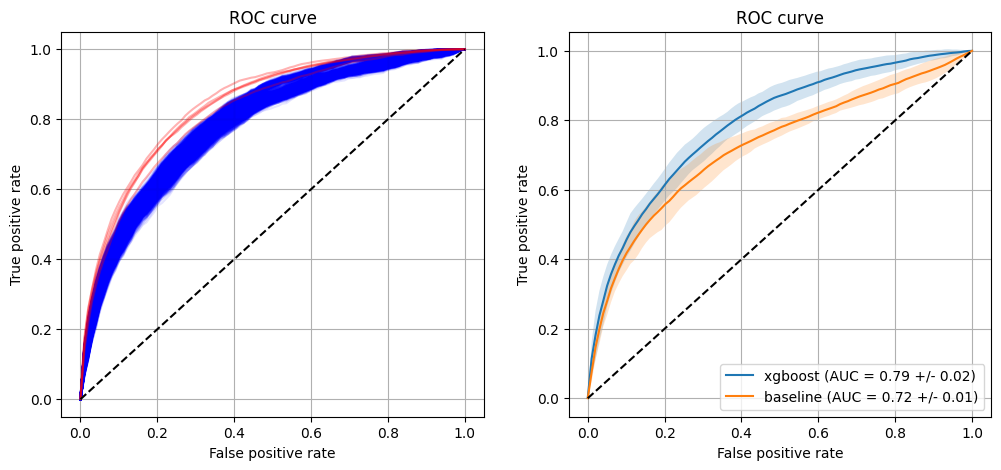

Z-score = 3.70
p-value = 0.0001


In [11]:

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i], 'b', alpha=0.1)
for i in range(len(tpr_train_list)):
    plt.plot(fpr, tpr_train_list[i], 'r', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
plt.fill_between(fpr, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr, tpr_mean, label=f'xgboost (AUC = {np.mean(auc_list):.2f} +/- {pd.Series(auc_list).std():.2f})')

#add baseline to the plot
df_baseline = pd.read_csv('data/baseline_roc.csv')
plt.fill_between(df_baseline.fpr, df_baseline.tpr - 2*df_baseline.tpr_std, df_baseline.tpr + 2*df_baseline.tpr_std, alpha=0.2)
plt.plot(df_baseline.fpr.values, df_baseline.tpr.values, label=f'baseline (AUC = {df_baseline.auc[0]:.2f} +/- {df_baseline.auc_std[0]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

Z_score = (np.mean(auc_list) - df_baseline.auc[0])/np.sqrt(df_baseline.auc_std[0]**2 + pd.Series(auc_list).std()**2)
print(f'Z-score = {Z_score:.2f}')
import scipy.stats
p_value = scipy.stats.norm.sf(abs(Z_score)) #one-sided
# p_value = 1 - 0.5*(1 + np.math.erf(Z_score/np.sqrt(2)))
print(f'p-value = {p_value:.4f}')


KeyboardInterrupt: 

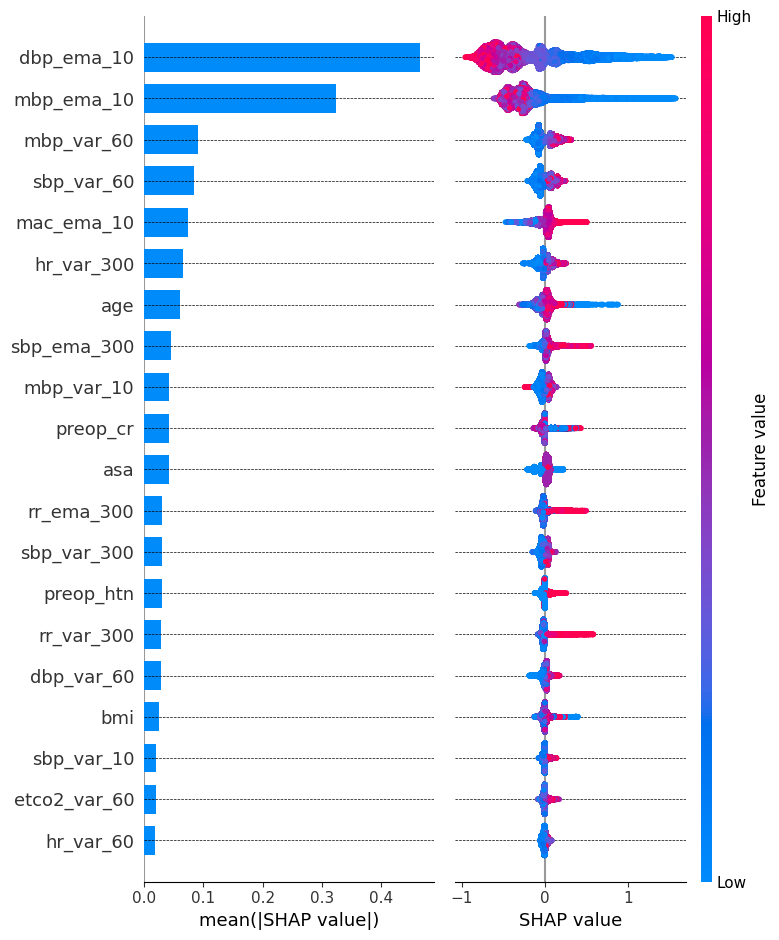

In [14]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 20
shap_values_tot = []
test_data = pd.DataFrame()
for cv, test in dataframe.groupby('cv_group'):
    model = xgb.Booster()
    model.load_model(f'data/models/xgb_{cv}.json')
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test[FEATURE_NAME])
    for shape in shap_values:
        shap_values_tot.append(shape)
    test_data= pd.concat([test_data, test[FEATURE_NAME]])

# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(np.array(shap_values_tot), test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean(|SHAP value|)')
plt.subplot(1, 2, 2)
shap.summary_plot(np.array(shap_values_tot), test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.savefig('./report/figures/shap_xgboost.pdf', bbox_inches='tight', dpi=600)
plt.show()

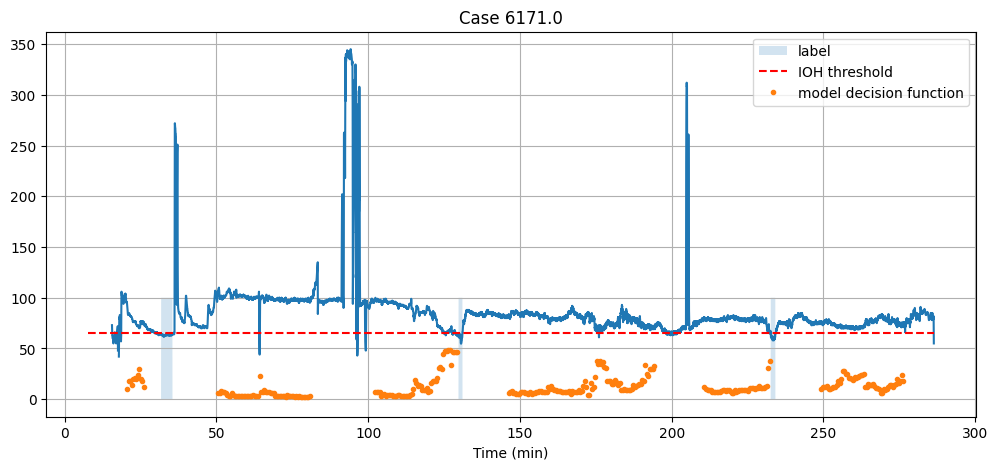

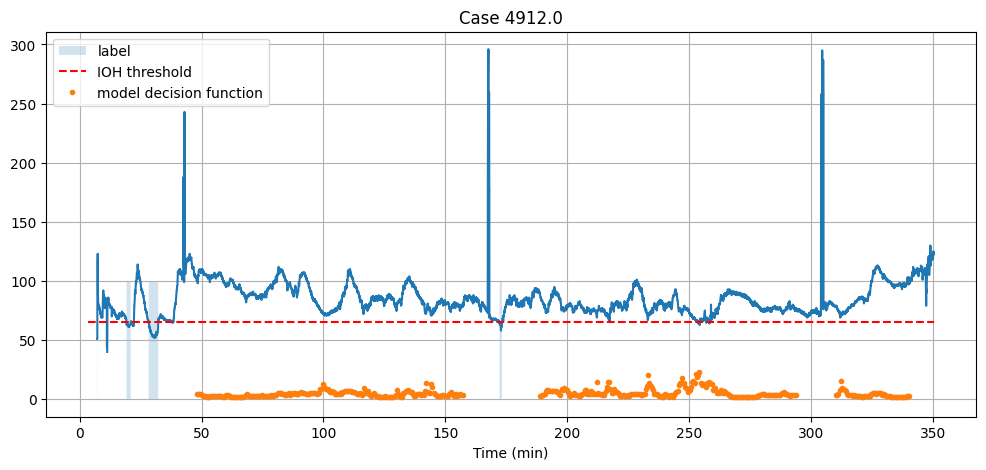

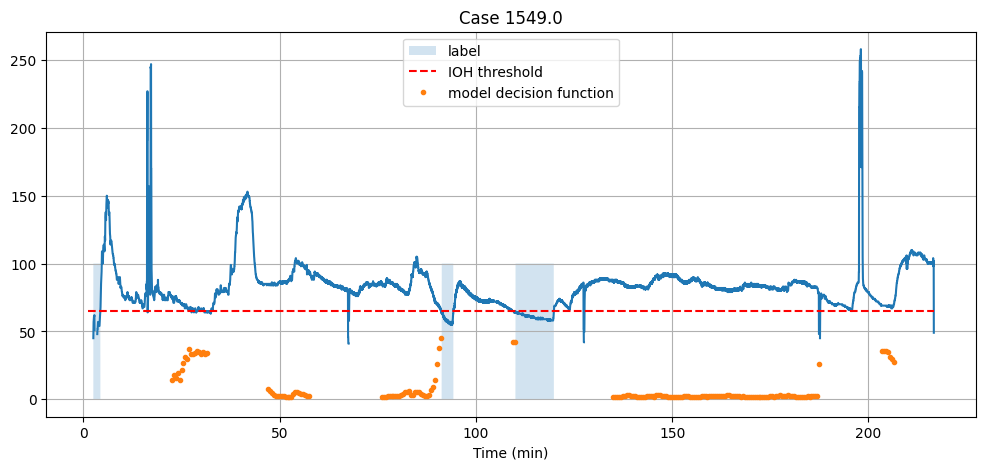

In [21]:
from scripts.dataLoader import label_caseid

np.random.seed(1)
cases = np.random.choice(dataframe['caseid'].unique(), 3, replace=False)

for case in cases:
    raw_case = rawData[rawData.caseid == case].copy()
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # removing the nan values at the beginning and the ending
    case_valid_mask = ~raw_case.mbp.isna()
    raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]


    raw_case= label_caseid(raw_case, 2)

    segment_data = dataframe[dataframe['caseid'] == case]
    cv_group = segment_data['cv_group'].values[0]


    segment_data = segment_data.dropna(subset=FEATURE_NAME)
    x_test = segment_data[FEATURE_NAME]
    y_test = segment_data['label'].values
    
    # load model
    model = xgb.XGBClassifier()
    model.load_model(f'data/models/xgb_{cv_group}.json')
    y_pred = model.predict_proba(x_test)[:, 1]

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case['Time']*2/60, np.zeros(len(raw_case['Time'])), raw_case.label*100, label='label', alpha=0.2)
    plt.plot(raw_case['Time']*2/60, raw_case['mbp'])
    plt.hlines(65, raw_case['Time'].values[0]/60, raw_case['Time'].values[-1]*2/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time']/60,y_pred*100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    # plt.xlim([35, 42])
    # plt.xlim([235, 245])
    # plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()